## Importing Libraries

In [61]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
from keras.callbacks import Callback
import seaborn as sns
import soundfile as sf
from scipy.io import wavfile as wav
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
%matplotlib inline

In [2]:
meta_data = pd.read_csv("UrbanSound8K.csv")  

np.shape(meta_data) # (8732, 8)
meta_data.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

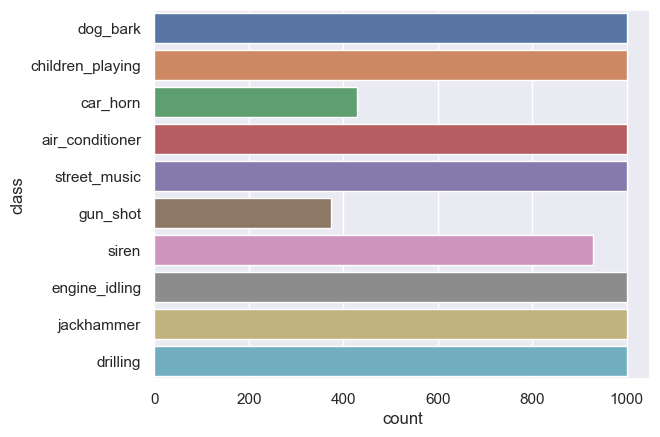

In [3]:
sns.set(style="darkgrid")
sns.countplot(y= meta_data['class'],orient='v')
plt.show()

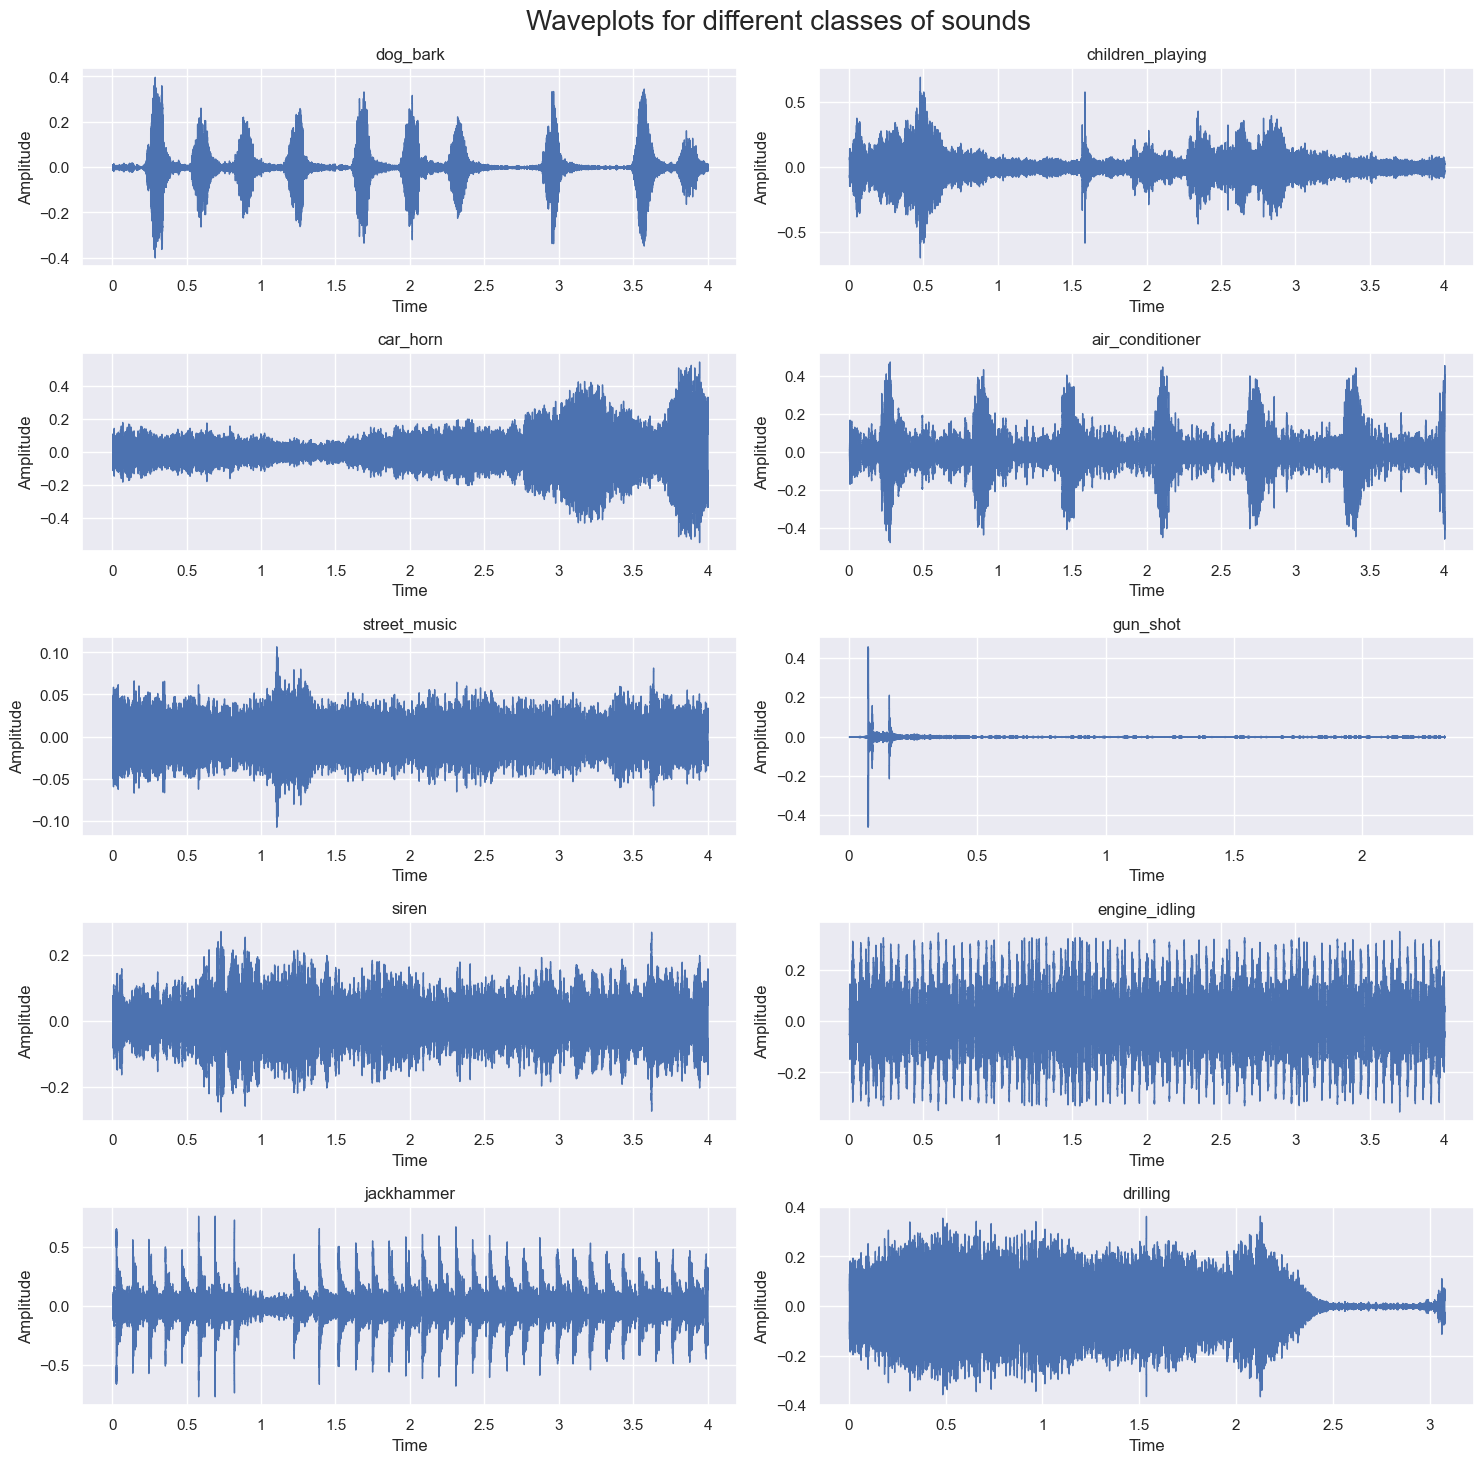

In [5]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
classes = list(meta_data['class'].unique()) 
plt.title('Waveplots for different classes of sounds\n',size=20)
plt.axis('off')
for i in range(10):
    fig.add_subplot(5,2,i+1)
    plt.title(classes[i])
    plt.ylabel('Amplitude')
    file_name = 'sample_sound/'+classes[i]+".wav"       
    data,sample_rate = librosa.load(file_name)
    librosa.display.waveshow(data,sr=sample_rate)
    plt.tight_layout()

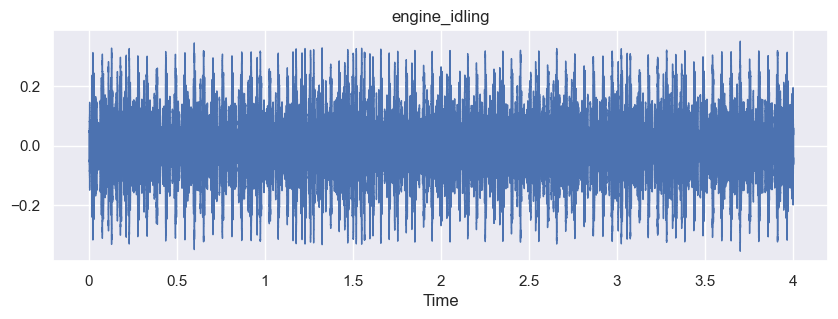

In [7]:
# Listening module for a sound class
i = 7
filename = 'sample_sound/'+classes[i]+".wav"
plt.figure(figsize=(10,3))
plt.title(classes[i])
data,sample_rate = librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

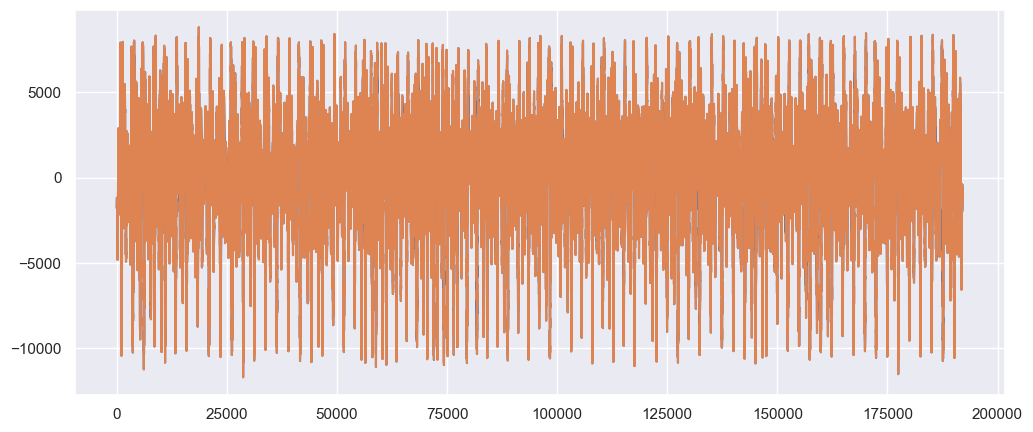

In [9]:
# Waveplot of original sound without getting normalized
from scipy.io import wavfile as wav
wave_sample_rate,wave_audio =wav.read(filename)
plt.figure(figsize=(12,5))
plt.plot(wave_audio)


### 1.2  Extracting the metadata of the audio

In [10]:
audio_d_list = []

for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('Audio_dataset/'),
                             'fold'+ str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    
    # extracting channels, sampling rate, bit rate and duration
    data = sf.SoundFile(file_name)
    duration = float(meta_data.iloc[index,3])-float(meta_data.iloc[index,2])
    audio_d_list.append([data.channels,
                         data.samplerate,
                         data.subtype[4:],
                         duration])

audio_property = pd.DataFrame(audio_d_list, 
                          columns=['num_channels','sample_rate','bit_depth','duration'])

In [11]:
audio_property.head()

num_channels  sample_rate bit_depth  duration
0             2        44100        16  0.317551
1             2        44100        16  4.000000
2             2        44100        16  4.000000
3             2        44100        16  4.000000
4             2        44100        16  4.000000

## 2. Inital Data Analysis

### Spectogram for different classes 

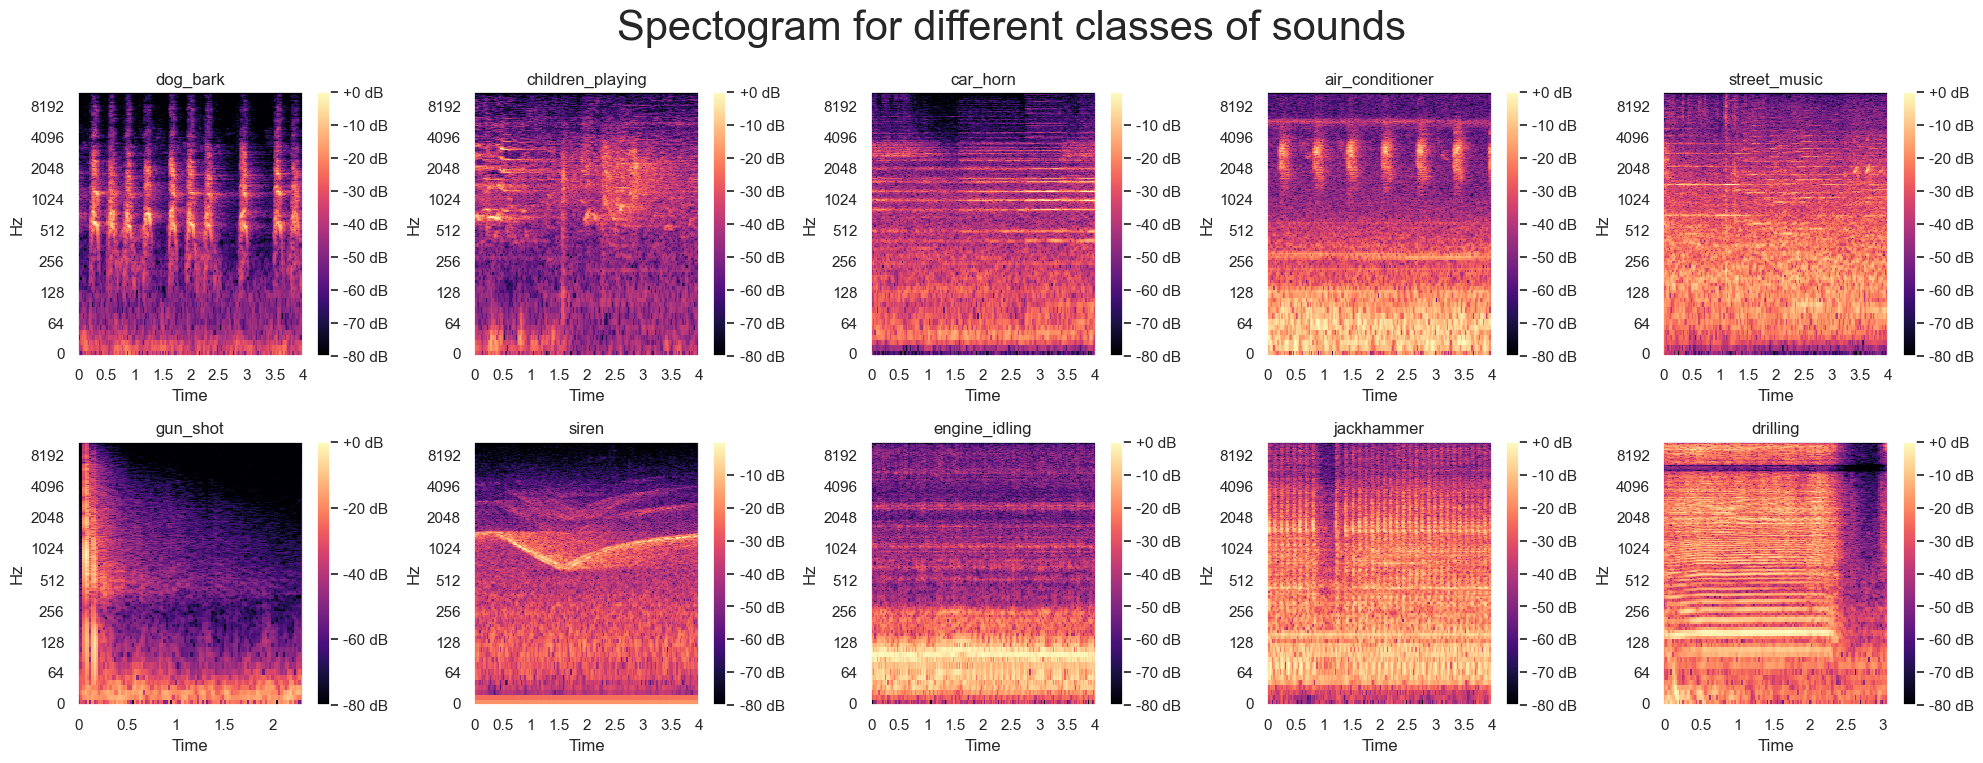

In [13]:
fig = plt.figure(figsize=(20, 8))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
classes = list(meta_data['class'].unique()) 
plt.title('Spectogram for different classes of sounds\n',size=30)
plt.axis('off')
for i in range(10):
    fig.add_subplot(2,5,i+1)
    plt.title(classes[i])
    file_name = 'sample_sound/'+classes[i]+".wav"
    data,sample_rate = librosa.load(file_name)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, x_axis = "time",y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

### 2.1   Duration of Audio

In [14]:
print(audio_property.duration)

0       0.317551
1       4.000000
2       4.000000
3       4.000000
4       4.000000
          ...   
8727    4.000000
8728    2.142545
8729    3.505983
8730    2.532098
8731    2.532099
Name: duration, Length: 8732, dtype: float64


### 2.2 Number of Channels

Sound Channel refers to the independent audio signal which is collected or playback when the sound is recording or playback in different spatial position. Therefore, the number of channel is the amount of sound source when the sound is recording or the relevant speaker number when it is playback

In [15]:
print(audio_property.num_channels.value_counts(normalize=True))

2    0.915369
1    0.084631
Name: num_channels, dtype: float64


### 2.3 Bit Depth

Bit depth describes the resolution of the sound data that is captured and stored in an audio file. A higher audio bit depth indicates a more detailed sound recording.

In [16]:
print(audio_property.bit_depth.value_counts(normalize=True))

16       0.659414
24       0.315277
T        0.019354
U8       0.004924
DPCM     0.000916
ADPCM    0.000115
Name: bit_depth, dtype: float64


### 2.4 Sampling Frequency or Sample Rate

In audio production, a sample rate (or "sampling frequency") defines how many times per second a sound is sampled. Technically speaking, it is the frequency of samples used in a digital recording. 

In [17]:
print(audio_property.sample_rate.value_counts(normalize=True))

44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: sample_rate, dtype: float64


## 3. Data Pre-Processing

Using Librosa’s load() function:  
* Converts the sampling rate to 22.05 KHz
* Normalise the Bit-depth values of the audio
* Merge the audio channels to Mono (a single channel) 

Using Librosa MFCC function: 
* Extracting Mel Frequency Cepstral Coefficient 

In [152]:
def feature_extractor(file_name,scale,padding,max_pad,n):
    '''
    Function to extract features from the audio file
    Does the following things using Librosa library:
        - Converts the sampling rate to 22.05 KHz
        - Normalize the Bit-depth values of the audio
        - Merge the audio channels into a Mono (single) channel
    Parameters: 
    Input:
        file_name : string; 
                    Path of the file to be processed 
        scale : False; 
                True when 1D features are required calculated 
                by taking mean along the axis
        padding : False; 
                  True when 2D features are required with padding
        max_pad : None [int]; 
                  Maxium size of a padded image/array. 
                  Required when padding is set to True
        n = 40 [int]; 
            Number of MFCCs to return          
    Output:
        mfccs = array of mfccs features.
                (1D when scaling = True
                 2D when padding = True)   
    '''
    try:        
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        
        mfccs = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = n) 
            
        if padding:
            pad_width = max_pad - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            
        if scale: 
            mfccs = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

### 1-Dimensional Feature Extraction

In [19]:
feat_list = []
for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('Audio_dataset/'),
                             'fold'+str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    class_label = row["class"]
    
    data = feature_extractor(file_name,scale=True)
    feat_list.append([data, class_label])

features_1D = pd.DataFrame(feat_list, columns=['feature','class_label'])

print('Processed ', len(features_1D), ' files')
print('Output Feature shape ',np.shape(features_1D.iloc[0,0]))

C:\Users\daksh\anaconda3\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
C:\Users\daksh\anaconda3\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\daksh\anaconda3\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Processed  8732  files
Output Feature shape  (40,)


In [24]:
features_1D.to_pickle("features_1D.pkl")

### 2-Dimensional Feature Extraction with and without Padding

In [20]:
feat_list = []
feat_list_padded = []
for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('Audio_dataset/'),
                             'fold'+ str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    class_label = row["class"]
    class_id = row["classID"]
    
    data = feature_extractor(file_name)
    feat_list.append([data, class_id])
    
    data = feature_extractor(file_name,padding=True,max_pad = 174)
    feat_list_padded.append([data, class_label])
    
features_wo_pad = pd.DataFrame(feat_list, columns=['feature','class_label'])
features_2D = pd.DataFrame(feat_list_padded, columns=['feature','class_label'])

print('Processed ', len(features_2D), ' files')
print('Output Feature Padded shape ',np.shape(features_2D.iloc[0,0]))

C:\Users\daksh\anaconda3\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
C:\Users\daksh\anaconda3\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\daksh\anaconda3\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Processed  8732  files
Output Feature Padded shape  (40, 174)


In [25]:
features_wo_pad.to_pickle("features_wo_pad.pkl")
features_2D.to_pickle("features_2D.pkl")

In [26]:
features_1D = pd.read_pickle("features_1D.pkl")
features_2D = pd.read_pickle("features_2D.pkl")
features_wo_pad = pd.read_pickle("features_wo_pad.pkl")

### Data Visualization after MFCC

In [27]:
# choose a sample of sound from each class

sound_class_dic = meta_data.groupby(['class', 'classID']).size()
sound_sample = []

for c in range(10):
    for index, row in features_wo_pad.iterrows():
        if c == row['class_label']:
            sound_sample.append(row)
            break

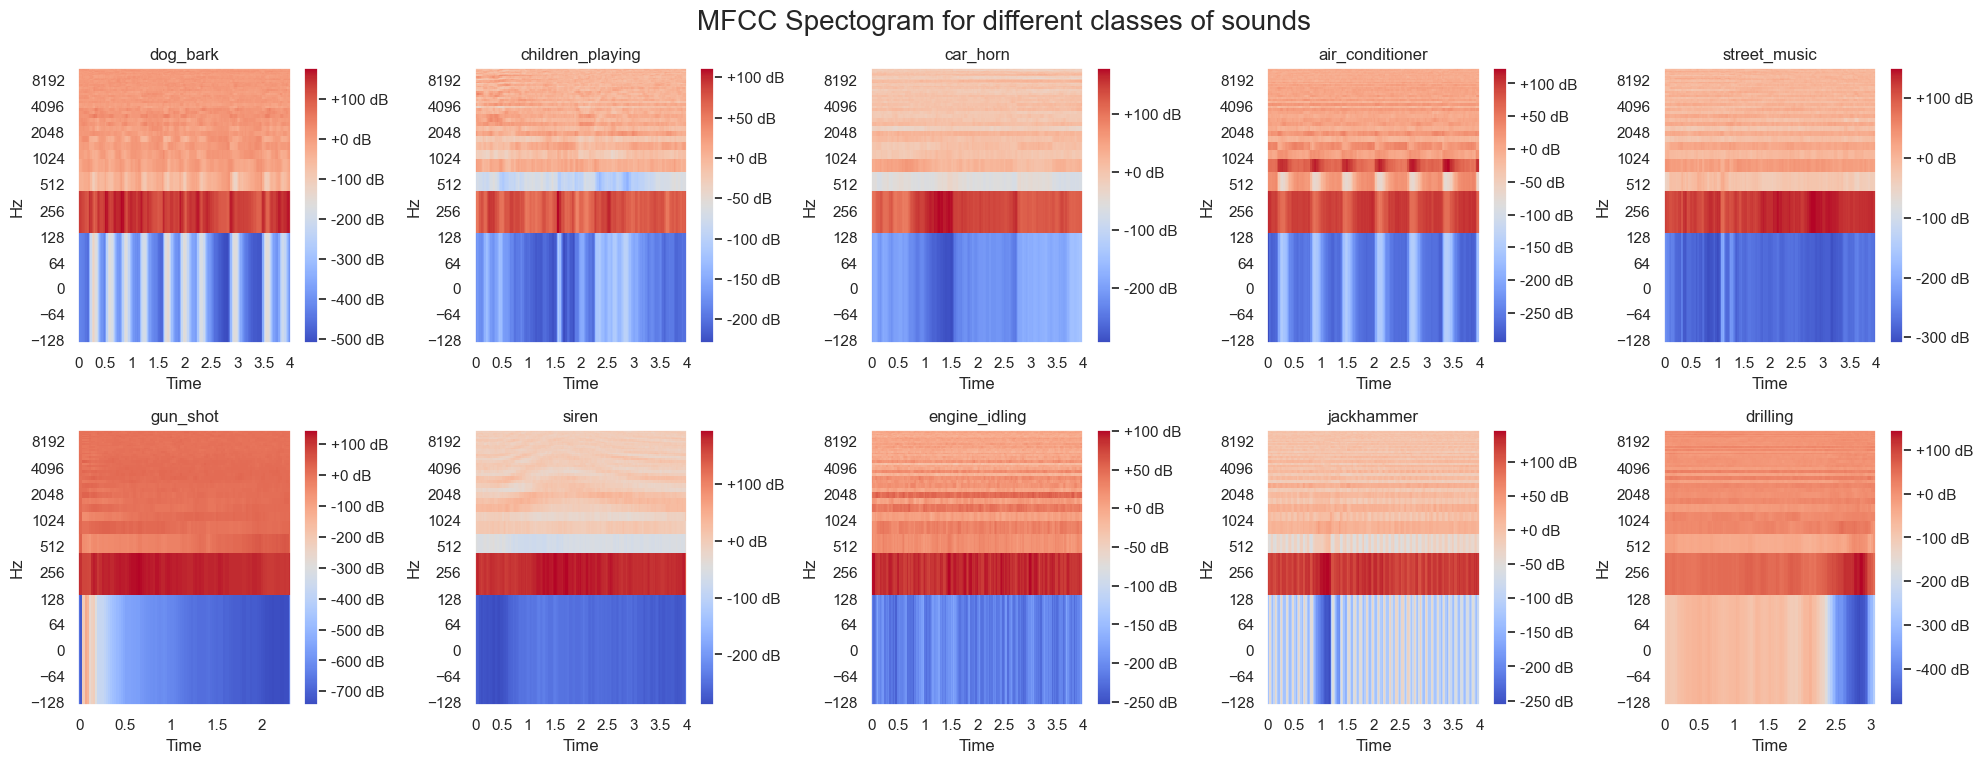

In [28]:
fig = plt.figure(figsize=(20, 8))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
classes = list(meta_data['class'].unique()) 
plt.title('MFCC Spectogram for different classes of sounds\n',size=20)
plt.axis('off')
for i in range(10):
    fig.add_subplot(2,5,i+1)
    plt.title(classes[i])
    plt.ylabel('Amplitude')
    file_name = 'sample_sound/'+classes[i]+".wav"
    mfcc_ = feature_extractor(file_name)
    #mfcc_ = feature_extractor(file_name,padding=True,max_pad=174)
    librosa.display.specshow(mfcc_,x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

### Label Encoding

In [29]:
# Convert features and corresponding classification labels into numpy arrays
X_1D = np.array(features_1D.feature.tolist())
y_1D = np.array(features_1D.class_label.tolist())

# Encode the classification labels
label_encoder = LabelEncoder()
yy_1D = to_categorical(label_encoder.fit_transform(y_1D))

In [30]:
# Convert features and corresponding classification labels into numpy arrays
X_2D = np.array(features_2D.feature.tolist())
y_2D = np.array(features_2D.class_label.tolist())

# Encode the classification labels
yy_2D = to_categorical(label_encoder.transform(y_2D)) 

### Splitting the Dataset

In [31]:
x_train_sl_1D, x_test_sl_1D, y_train_sl_1D, y_test_sl_1D = train_test_split(X_1D,y_1D,test_size=0.2,random_state =27)

# x_train_sl_2D, x_test_sl_2D, y_train_sl_2D, y_test_sl_2D = train_test_split(
#     X_2D.reshape(X_2D.shape[0],X_2D.shape[1]*X_2D.shape[2]),yy_2D,test_size=0.2,random_state = 42)

x_train_1D, x_test_1D, y_train_1D, y_test_1D = train_test_split(X_1D, yy_1D, test_size=0.2, random_state = 27)
x_train_2D, x_test_2D, y_train_2D, y_test_2D = train_test_split(X_2D, yy_2D, test_size=0.2, random_state = 27)

# Classification using Different Algorithms

Following will be used for classification:    
    
1. Random Forest
2. Support Vector Machine 
2. Mulit-layer Perceptron (ANN)
3. Convolutional Neural Network (CNN)

## 1. Random Forest Classification 

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [33]:
clf = RandomForestClassifier(max_depth=4, random_state=0,n_estimators=100)
clf.fit(x_train_sl_1D,y_train_sl_1D)
y_pred = clf.predict(x_test_sl_1D)
train_accu =  clf.score(x_train_sl_1D, y_train_sl_1D)
test_accu = clf.score(x_test_sl_1D, y_test_sl_1D)
print('Training Accuracy:', train_accu)
print('Test Accuracy:', test_accu)

Training Accuracy: 0.5712240515390121
Test Accuracy: 0.5334859759587864


###    **!! Not so Good !!**

## 2. Support Vector Machine   

In [35]:
import pickle
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Grid Search for hyper parameter selection

In [36]:
#search the hyperparameter space to find the best model
tuned_parameters = [{'kernel': ['rbf'], 
                     'gamma': [1e-3, 1e-4, 1e-5],
                     'C': [1, 10 ,20,30,40,50]}]
#                    , {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
searchpara = GridSearchCV(svm.SVC(), tuned_parameters)
searchpara.fit(x_train_sl_1D, y_train_sl_1D)
searchpara.best_params_

{'C': 50, 'gamma': 0.0001, 'kernel': 'rbf'}

### Model Execution

In [37]:
# construct the model by the best hyperparameters found above
SVM = svm.SVC(C=50.0, gamma=0.001)

# train the model
SVM.fit(x_train_sl_1D,y_train_sl_1D)

y_pred = SVM.predict(x_test_sl_1D)


In [38]:
train_accu =  SVM.score(x_train_sl_1D, y_train_sl_1D)
test_accu = SVM.score(x_test_sl_1D, y_test_sl_1D)

print('Training Accuracy: %.4f%%'% (train_accu*100))
print('Test Accuracy: %.4f%%'% (test_accu*100))

Training Accuracy: 99.8712%
Test Accuracy: 89.8111%


### Confusion Matrix

In [39]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize = (8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

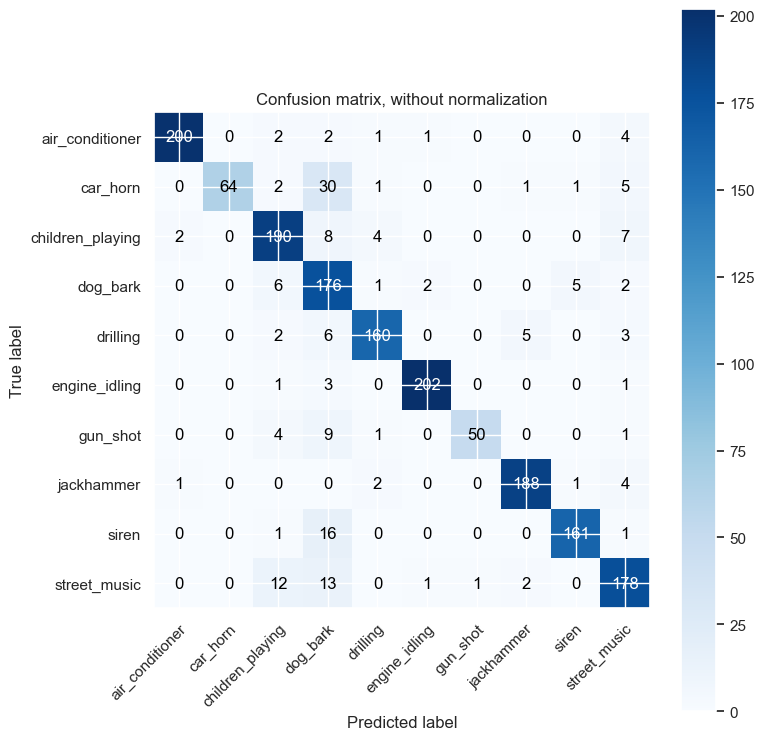

In [40]:
class_names = meta_data.groupby(['class', 'classID'], as_index = False).sum()['class']
plot_confusion_matrix(y_test_sl_1D, y_pred, classes=class_names, cmap=plt.cm.Blues)
plt.show()

## 3. Multi-Layer perceptron

In [42]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn import metrics 
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 

In [78]:
n_labels = yy_1D.shape[1]
in_shape = x_train_1D.shape[1]
n_layers = 2
n_nodes = 100

model_num = 4

# Construct model 
model = Sequential()

model.add(Dense(n_nodes, input_shape=(in_shape,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_nodes))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Model Summary

In [79]:
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_train_1D, y_train_1D, verbose=0)
accuracy = 100*score[1] 

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               4100      
                                                                 
 activation_9 (Activation)   (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 activation_10 (Activation)  (None, 100)               0         
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)               

### Model Execution

In [80]:
n_epochs = 100
n_batch = 32

start = datetime.now()

history = model.fit(x_train_1D, 
                    y_train_1D,
                    batch_size=n_batch,
                    epochs=n_epochs,
                    validation_data=(x_test_1D, y_test_1D),
                    verbose=1)

duration = datetime.now() - start
print("Training finished in time: ", duration)

Epoch 1/100
219/219 [==============================] - 1s 2ms/step - loss: 12.5780 - accuracy: 0.1681 - val_loss: 2.0046 - val_accuracy: 0.3097
Epoch 2/100
219/219 [==============================] - 0s 2ms/step - loss: 2.7194 - accuracy: 0.2301 - val_loss: 1.9956 - val_accuracy: 0.3314
Epoch 3/100
219/219 [==============================] - 0s 2ms/step - loss: 2.1957 - accuracy: 0.2674 - val_loss: 1.8807 - val_accuracy: 0.3749
Epoch 4/100
219/219 [==============================] - 0s 2ms/step - loss: 2.0279 - accuracy: 0.3111 - val_loss: 1.7475 - val_accuracy: 0.4493
Epoch 5/100
219/219 [==============================] - 0s 2ms/step - loss: 1.8812 - accuracy: 0.3569 - val_loss: 1.6417 - val_accuracy: 0.4814
Epoch 6/100
219/219 [==============================] - 0s 2ms/step - loss: 1.7719 - accuracy: 0.3956 - val_loss: 1.5838 - val_accuracy: 0.4991
Epoch 7/100
219/219 [==============================] - 0s 2ms/step - loss: 1.7203 - accuracy: 0.4202 - val_loss: 1.4969 - val_accuracy: 0.525

Epoch 58/100
219/219 [==============================] - 0s 2ms/step - loss: 1.0077 - accuracy: 0.6588 - val_loss: 0.8253 - val_accuracy: 0.7464
Epoch 59/100
219/219 [==============================] - 0s 2ms/step - loss: 1.0020 - accuracy: 0.6588 - val_loss: 0.8136 - val_accuracy: 0.7338
Epoch 60/100
219/219 [==============================] - 0s 2ms/step - loss: 1.0039 - accuracy: 0.6511 - val_loss: 0.8128 - val_accuracy: 0.7384
Epoch 61/100
219/219 [==============================] - 0s 2ms/step - loss: 0.9857 - accuracy: 0.6606 - val_loss: 0.7929 - val_accuracy: 0.7384
Epoch 62/100
219/219 [==============================] - 0s 2ms/step - loss: 0.9760 - accuracy: 0.6686 - val_loss: 0.7910 - val_accuracy: 0.7418
Epoch 63/100
219/219 [==============================] - 0s 2ms/step - loss: 0.9788 - accuracy: 0.6620 - val_loss: 0.7956 - val_accuracy: 0.7533
Epoch 64/100
219/219 [==============================] - 0s 2ms/step - loss: 0.9810 - accuracy: 0.6690 - val_loss: 0.7928 - val_accuracy:

### Model Evalutaion

In [81]:
# Evaluating the model on the training and testing set
acc_train = model.evaluate(x_train_1D, y_train_1D, verbose=0)
print("Training Accuracy: ", acc_train[1])

acc_test = model.evaluate(x_test_1D, y_test_1D, verbose=0)
print("Testing Accuracy: ", acc_test[1])

Training Accuracy:  0.8210451006889343
Testing Accuracy:  0.7613050937652588


In [96]:
def plot_accuracy(history,n_epochs,n_batch):
    training_accuracy = history.history['accuracy']
    testing_accuracy = history.history['val_accuracy']  # Assuming you used 'val_accuracy' for testing accuracy

# Create a list of epoch numbers
    epochs = range(1, n_epochs + 1)

# Plot both training and testing accuracy
    plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, testing_accuracy, 'r', label='Testing Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    


In [104]:
def plot_losses(history,n_epochs):
    train_losses = history.history['loss']
    test_losses = history.history['val_loss']  # Assuming you used 'val_loss' for validation loss

# Create a list of epoch numbers
    epochs = range(1, len(train_losses) + 1)

# Plot training and validation losses
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, test_losses, 'r', label='Validation Loss')
    plt.title('Training and Testing Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Case 1: Epochs=100, No_batch=32

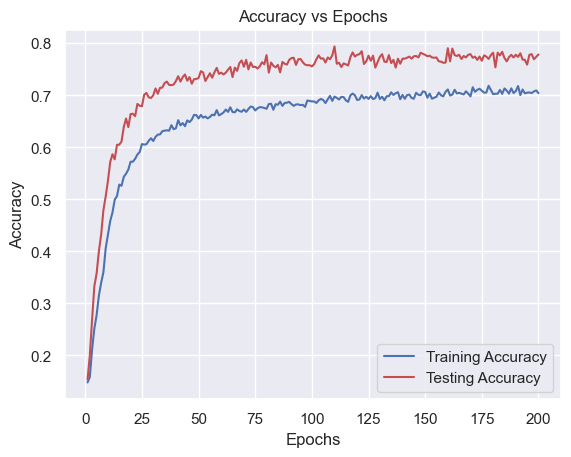

In [97]:
plot_accuracy(history,n_epochs,32)

### Model Execution after doing some changes in Hyperparameters

1. Set n_epoch= 200
2. num_of_batch= 64

In [91]:
model_3 = Sequential()

model_3.add(Dense(n_nodes, input_shape=(in_shape,)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(n_nodes))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(n_labels))
model_3.add(Activation('softmax'))

model_3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [92]:
n_epochs_2=200
n_batch_2=16
start = datetime.now()

history = model_3.fit(x_train_1D, 
                    y_train_1D,
                    batch_size=n_batch_2,
                    epochs=n_epochs_2,
                    validation_data=(x_test_1D, y_test_1D),
                    verbose=1)

duration = datetime.now() - start
print("Training finished in time: ", duration)

Epoch 1/200
437/437 [==============================] - 1s 2ms/step - loss: 9.9619 - accuracy: 0.1482 - val_loss: 2.1924 - val_accuracy: 0.1540
Epoch 2/200
437/437 [==============================] - 1s 1ms/step - loss: 2.4366 - accuracy: 0.1585 - val_loss: 2.1705 - val_accuracy: 0.1998
Epoch 3/200
437/437 [==============================] - 1s 1ms/step - loss: 2.2086 - accuracy: 0.2113 - val_loss: 2.0403 - val_accuracy: 0.2685
Epoch 4/200
437/437 [==============================] - 1s 2ms/step - loss: 2.0906 - accuracy: 0.2517 - val_loss: 1.9333 - val_accuracy: 0.3331
Epoch 5/200
437/437 [==============================] - 1s 1ms/step - loss: 1.9878 - accuracy: 0.2775 - val_loss: 1.8224 - val_accuracy: 0.3578
Epoch 6/200
437/437 [==============================] - 1s 1ms/step - loss: 1.8943 - accuracy: 0.3152 - val_loss: 1.7304 - val_accuracy: 0.4001
Epoch 7/200
437/437 [==============================] - 1s 1ms/step - loss: 1.8242 - accuracy: 0.3396 - val_loss: 1.6243 - val_accuracy: 0.4322

Epoch 58/200
437/437 [==============================] - 1s 1ms/step - loss: 0.9672 - accuracy: 0.6716 - val_loss: 0.7649 - val_accuracy: 0.7527
Epoch 59/200
437/437 [==============================] - 1s 1ms/step - loss: 0.9794 - accuracy: 0.6614 - val_loss: 0.7906 - val_accuracy: 0.7413
Epoch 60/200
437/437 [==============================] - 1s 2ms/step - loss: 0.9981 - accuracy: 0.6639 - val_loss: 0.7792 - val_accuracy: 0.7436
Epoch 61/200
437/437 [==============================] - 1s 1ms/step - loss: 0.9876 - accuracy: 0.6670 - val_loss: 0.7571 - val_accuracy: 0.7401
Epoch 62/200
437/437 [==============================] - 1s 2ms/step - loss: 0.9770 - accuracy: 0.6727 - val_loss: 0.7845 - val_accuracy: 0.7436
Epoch 63/200
437/437 [==============================] - 1s 1ms/step - loss: 0.9852 - accuracy: 0.6681 - val_loss: 0.7910 - val_accuracy: 0.7493
Epoch 64/200
437/437 [==============================] - 1s 1ms/step - loss: 0.9589 - accuracy: 0.6770 - val_loss: 0.7799 - val_accuracy:

Epoch 115/200
437/437 [==============================] - 1s 1ms/step - loss: 0.9166 - accuracy: 0.6903 - val_loss: 0.7119 - val_accuracy: 0.7596
Epoch 116/200
437/437 [==============================] - 1s 1ms/step - loss: 0.9201 - accuracy: 0.6875 - val_loss: 0.7415 - val_accuracy: 0.7573
Epoch 117/200
437/437 [==============================] - 1s 1ms/step - loss: 0.9224 - accuracy: 0.6999 - val_loss: 0.7100 - val_accuracy: 0.7733
Epoch 118/200
437/437 [==============================] - 1s 1ms/step - loss: 0.8951 - accuracy: 0.7034 - val_loss: 0.7055 - val_accuracy: 0.7825
Epoch 119/200
437/437 [==============================] - 1s 1ms/step - loss: 0.8864 - accuracy: 0.7001 - val_loss: 0.7120 - val_accuracy: 0.7745
Epoch 120/200
437/437 [==============================] - 1s 1ms/step - loss: 0.8993 - accuracy: 0.6911 - val_loss: 0.7055 - val_accuracy: 0.7779
Epoch 121/200
437/437 [==============================] - 1s 1ms/step - loss: 0.9095 - accuracy: 0.6921 - val_loss: 0.7111 - val_ac

437/437 [==============================] - 1s 1ms/step - loss: 0.8565 - accuracy: 0.7155 - val_loss: 0.6824 - val_accuracy: 0.7722
Epoch 172/200
437/437 [==============================] - 1s 1ms/step - loss: 0.8663 - accuracy: 0.7068 - val_loss: 0.6857 - val_accuracy: 0.7745
Epoch 173/200
437/437 [==============================] - 1s 1ms/step - loss: 0.8739 - accuracy: 0.7105 - val_loss: 0.7058 - val_accuracy: 0.7682
Epoch 174/200
437/437 [==============================] - 1s 1ms/step - loss: 0.8616 - accuracy: 0.7127 - val_loss: 0.6788 - val_accuracy: 0.7745
Epoch 175/200
437/437 [==============================] - 1s 1ms/step - loss: 0.8579 - accuracy: 0.7088 - val_loss: 0.7036 - val_accuracy: 0.7665
Epoch 176/200
437/437 [==============================] - 1s 2ms/step - loss: 0.8759 - accuracy: 0.7051 - val_loss: 0.6807 - val_accuracy: 0.7768
Epoch 177/200
437/437 [==============================] - 1s 2ms/step - loss: 0.8721 - accuracy: 0.7054 - val_loss: 0.6797 - val_accuracy: 0.7745

### Case 2: Epochs=200, No_batch=16

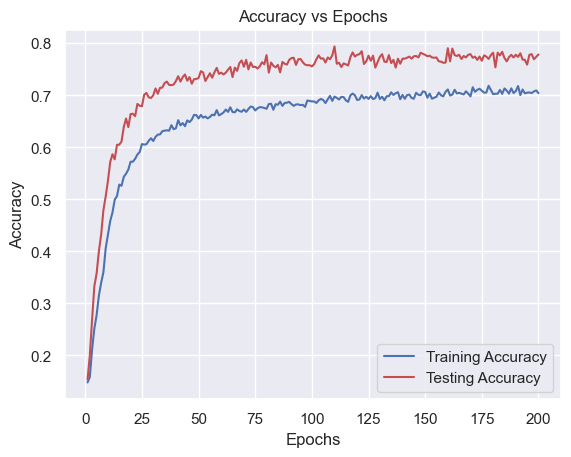

In [99]:
plot_accuracy(history,n_epochs_2,n_batch_2)


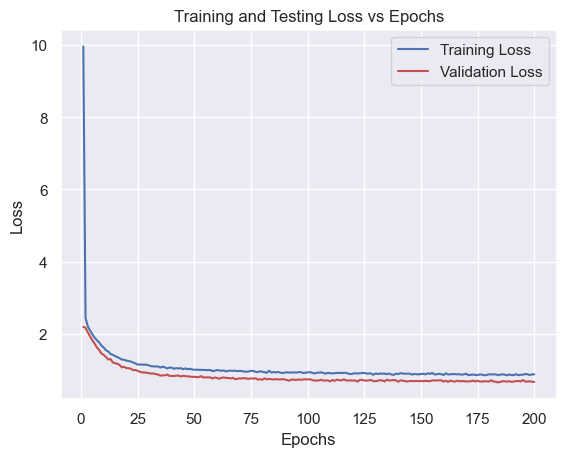

In [105]:
plot_losses(history,n_epochs_2)

## 4. Convolutional Neural Network

In [110]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn import metrics 
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
from keras.models import model_from_json


### Data reshaping 

In [111]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train_2D = x_train_2D.reshape(x_train_2D.shape[0], num_rows, num_columns, num_channels)
x_test_2D = x_test_2D.reshape(x_test_2D.shape[0], num_rows, num_columns, num_channels)

num_labels = yy_2D.shape[1]
filter_size = 2

### Model Definition

In [112]:
# Model Configuration

cnn_model_num = 5

n_labels = yy_1D.shape[1]
n_conv_layers = 4
n_mlp_layers = 2

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
#model.add(GlobalAveragePooling2D())

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Summarizing Model

In [114]:
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test_2D, y_test_2D, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 86, 16)        0         
 D)                                                              
                                                                 
 dropout_12 (Dropout)        (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 42, 32)         0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 9, 42, 32)        

### Model Execution

In [115]:
num_epochs = 200
num_batch_size = 256

start = datetime.now()

history = model.fit(x_train_2D, 
          y_train_2D, 
          batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(x_test_2D, y_test_2D),  
          verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
28/28 [==============================] - 20s 666ms/step - loss: 5.2682 - accuracy: 0.1210 - val_loss: 2.2766 - val_accuracy: 0.1923
Epoch 2/200
28/28 [==============================] - 16s 583ms/step - loss: 2.2443 - accuracy: 0.1626 - val_loss: 2.2073 - val_accuracy: 0.2210
Epoch 3/200
28/28 [==============================] - 15s 554ms/step - loss: 2.1717 - accuracy: 0.1980 - val_loss: 2.1329 - val_accuracy: 0.2553
Epoch 4/200
28/28 [==============================] - 16s 556ms/step - loss: 2.1056 - accuracy: 0.2206 - val_loss: 2.0706 - val_accuracy: 0.2822
Epoch 5/200
28/28 [==============================] - 15s 554ms/step - loss: 2.0502 - accuracy: 0.2487 - val_loss: 2.0159 - val_accuracy: 0.2833
Epoch 6/200
28/28 [==============================] - 15s 554ms/step - loss: 1.9452 - accuracy: 0.2805 - val_loss: 1.9698 - val_accuracy: 0.2753
Epoch 7/200
28/28 [==============================] - 16s 563ms/step - loss: 1.8753 - accuracy: 0.3026 - val_loss: 1.9002 - val_accuracy:

28/28 [==============================] - 27s 949ms/step - loss: 0.4787 - accuracy: 0.8381 - val_loss: 0.5100 - val_accuracy: 0.8226
Epoch 58/200
28/28 [==============================] - 31s 1s/step - loss: 0.4641 - accuracy: 0.8491 - val_loss: 0.5132 - val_accuracy: 0.8254
Epoch 59/200
28/28 [==============================] - 24s 848ms/step - loss: 0.4723 - accuracy: 0.8395 - val_loss: 0.5301 - val_accuracy: 0.8254
Epoch 60/200
28/28 [==============================] - 23s 835ms/step - loss: 0.4605 - accuracy: 0.8455 - val_loss: 0.5058 - val_accuracy: 0.8317
Epoch 61/200
28/28 [==============================] - 28s 1s/step - loss: 0.4571 - accuracy: 0.8462 - val_loss: 0.4722 - val_accuracy: 0.8443
Epoch 62/200
28/28 [==============================] - 24s 836ms/step - loss: 0.4267 - accuracy: 0.8553 - val_loss: 0.4744 - val_accuracy: 0.8454
Epoch 63/200
28/28 [==============================] - 23s 821ms/step - loss: 0.4366 - accuracy: 0.8545 - val_loss: 0.4502 - val_accuracy: 0.8454
Epoc

28/28 [==============================] - 15s 545ms/step - loss: 0.2032 - accuracy: 0.9311 - val_loss: 0.3243 - val_accuracy: 0.9004
Epoch 114/200
28/28 [==============================] - 15s 546ms/step - loss: 0.2181 - accuracy: 0.9273 - val_loss: 0.3581 - val_accuracy: 0.8884
Epoch 115/200
28/28 [==============================] - 15s 551ms/step - loss: 0.2064 - accuracy: 0.9330 - val_loss: 0.3236 - val_accuracy: 0.8998
Epoch 116/200
28/28 [==============================] - 15s 544ms/step - loss: 0.1998 - accuracy: 0.9331 - val_loss: 0.3351 - val_accuracy: 0.8964
Epoch 117/200
28/28 [==============================] - 15s 542ms/step - loss: 0.1864 - accuracy: 0.9353 - val_loss: 0.3185 - val_accuracy: 0.9021
Epoch 118/200
28/28 [==============================] - 15s 546ms/step - loss: 0.2026 - accuracy: 0.9331 - val_loss: 0.3181 - val_accuracy: 0.8998
Epoch 119/200
28/28 [==============================] - 15s 547ms/step - loss: 0.2089 - accuracy: 0.9287 - val_loss: 0.3094 - val_accuracy:

28/28 [==============================] - 15s 546ms/step - loss: 0.1297 - accuracy: 0.9575 - val_loss: 0.2606 - val_accuracy: 0.9222
Epoch 170/200
28/28 [==============================] - 667s 25s/step - loss: 0.1293 - accuracy: 0.9540 - val_loss: 0.2969 - val_accuracy: 0.9101
Epoch 171/200
28/28 [==============================] - 22s 797ms/step - loss: 0.1324 - accuracy: 0.9553 - val_loss: 0.2921 - val_accuracy: 0.9187
Epoch 172/200
28/28 [==============================] - 16s 563ms/step - loss: 0.1273 - accuracy: 0.9565 - val_loss: 0.2622 - val_accuracy: 0.9210
Epoch 173/200
28/28 [==============================] - 16s 556ms/step - loss: 0.1237 - accuracy: 0.9606 - val_loss: 0.2671 - val_accuracy: 0.9262
Epoch 174/200
28/28 [==============================] - 16s 561ms/step - loss: 0.1173 - accuracy: 0.9603 - val_loss: 0.2959 - val_accuracy: 0.9136
Epoch 175/200
28/28 [==============================] - 16s 554ms/step - loss: 0.1170 - accuracy: 0.9593 - val_loss: 0.2643 - val_accuracy: 

In [116]:
# Evaluating the model on the training and testing set
cnn_acc_train = model.evaluate(x_train_2D, y_train_2D, verbose=0)
print("Training Accuracy: ", cnn_acc_train[1])

cnn_acc_test = model.evaluate(x_test_2D, y_test_2D, verbose=0)
print("Testing Accuracy: ", cnn_acc_test[1])

Training Accuracy:  0.9958482384681702
Testing Accuracy:  0.9170005917549133


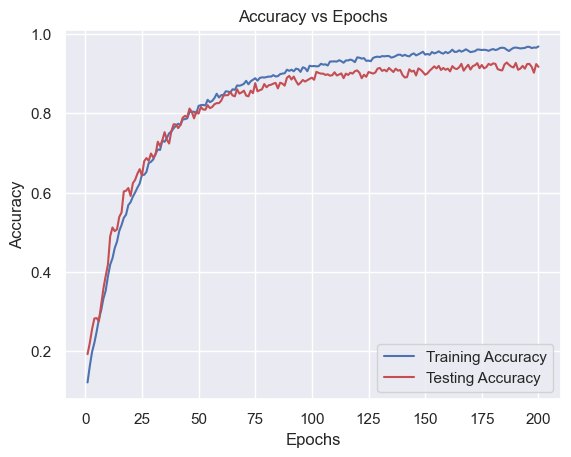

In [121]:
plot_accuracy(history,num_epochs,num_batch_size)

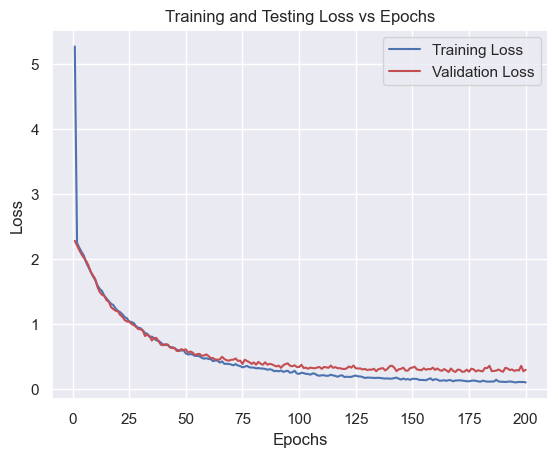

In [122]:
plot_losses(history,num_epochs)

In [123]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")


In [128]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [125]:
loaded_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
score = loaded_model.evaluate(x_test_2D, y_test_2D, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 91.70%


In [157]:
y_pred_2D = model.predict(x_test_2D)

55/55 [==============================] - 3s 24ms/step


In [204]:
def extract_features(file_name, max_pad=174, n=40):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n)
        
        # padding
        pad_width = max_pad - mfccs.shape[1]
        mfccs_pad = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        mfccsscaled = np.mean(mfccs.T, axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file:", file_name)
        return None 
     
    return mfccs, mfccs_pad, mfccsscaled

class_names= ['air_conditioner', 'car_horn','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music', ]
label_encoder_2D = LabelEncoder()
label_encoder_2D.fit(class_names)



def predict(file_name, max_pad=174, n=40):
    pred_features, pred_features_pad, pred_features_scaled = extract_features(file_name, max_pad, n)
    pred_feature = pred_features_pad.reshape(1, num_rows, num_columns, num_channels)

    pred_v = model.predict(pred_feature)
    preditcted_classes=np.argmax(pred_v, axis=1)
    pred_classes = label_encoder_2D.inverse_transform(preditcted_classes)
    print("The predicted class is:", pred_classes[0], '\n') 

#     predicted_proba_vector = model.predict_proba(pred_feature)
#     predicted_proba = predicted_proba_vector[0]
#     for i in range(len(predicted_proba)):
#         category = le.inverse_transform(np.array([i]))
#         print(category[0], "\t\t : ", format(predicted_proba[i], '.32f'))
    predicted_proba = pred_v[0]  # Get predicted probabilities directly from the predict method
    for i, prob in enumerate(predicted_proba):
        category = label_encoder_2D.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(prob, '.32f'))
        
        
predict('E:/Projects/Audio Classification/Audio_Classification_4_using_models_(Urbansound8 dataset)/Sample_sound/jackhammer.wav', max_pad=174, n=40)
ipd.Audio('E:/Projects/Audio Classification/Audio_Classification_4_using_models_(Urbansound8 dataset)/Sample_sound/jackhammer.wav')

1/1 [==============================] - 0s 37ms/step
The predicted class is: jackhammer 

air_conditioner 		 :  0.00000085888774492559605278074741
car_horn 		 :  0.00007206947339000180363655090332
children_playing 		 :  0.00000000190029836311111921531847
dog_bark 		 :  0.00000049399449153497698716819286
drilling 		 :  0.00069468154106289148330688476562
engine_idling 		 :  0.00000084055091065238229930400848
gun_shot 		 :  0.00000000169058578247671675853780
jackhammer 		 :  0.99922776222229003906250000000000
siren 		 :  0.00000259413604908331762999296188
street_music 		 :  0.00000073191415594919817522168159


In [205]:
predict('E:/Projects/Audio Classification/Audio_Classification_4_using_models_(Urbansound8 dataset)/Sample_sound/drilling.wav', max_pad=174, n=40)
ipd.Audio('E:/Projects/Audio Classification/Audio_Classification_4_using_models_(Urbansound8 dataset)/Sample_sound/drilling.wav')

1/1 [==============================] - 0s 39ms/step
The predicted class is: drilling 

air_conditioner 		 :  0.00000000000000335794904049121525
car_horn 		 :  0.00000000000017995401989292364453
children_playing 		 :  0.00000000000000001570934270065795
dog_bark 		 :  0.00000000000011252517608017001405
drilling 		 :  1.00000000000000000000000000000000
engine_idling 		 :  0.00000000000000000362152121243934
gun_shot 		 :  0.00000000000000195978796511703680
jackhammer 		 :  0.00000000005411809542166245989847
siren 		 :  0.00000000000005004095485964914214
street_music 		 :  0.00000000000000000051503403054000


### Predicting the class of other audios


In [195]:
predict('E:/Projects/Audio Classification/Audio_Classification_4_using_models_(Urbansound8 dataset)/Audio_dataset/fold4/22883-7-71-0.wav', max_pad=174, n=40)

1/1 [==============================] - 0s 33ms/step
The predicted class is: jackhammer 

air_conditioner 		 :  0.00000048977466349242604337632656
car_horn 		 :  0.00000689605349180055782198905945
children_playing 		 :  0.00000000001413362309132804028877
dog_bark 		 :  0.00000000074528205828983118408360
drilling 		 :  0.00000039481821545450657140463591
engine_idling 		 :  0.00000064945828626150614582002163
gun_shot 		 :  0.00000000011368068292272326402781
jackhammer 		 :  0.99999165534973144531250000000000
siren 		 :  0.00000001686096595676644938066602
street_music 		 :  0.00000000114699827413744515069993


In [187]:
## checking whether the path exists or not
os.path.exists('E:/Projects/Audio Classification/Audio_Classification_4_using_models_(Urbansound8 dataset)/electric-drill-01.wav')

True

## Confusion Matrix for CNN Model

<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

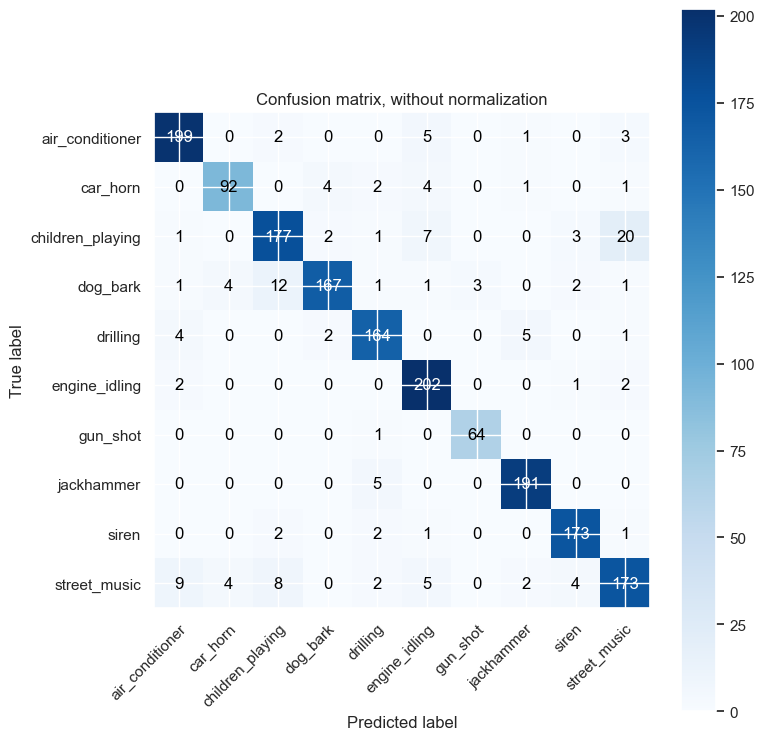

In [203]:
# Convert one-hot encoded predictions back to class indices
class_names = meta_data.groupby(['class', 'classID'], as_index = False).sum()['class']
y_pred_indices = np.argmax(y_pred_2D, axis=1)

# Convert one-hot encoded true labels back to class indices
y_true_indices = np.argmax(y_test_2D, axis=1)

# Call the plot_confusion_matrix function with class indices
plot_confusion_matrix(y_true_indices, y_pred_indices, classes=class_names, cmap=plt.cm.Blues)


In [201]:
num_classes = len(np.unique(y_pred_indices))
print(num_classes)

10


## Results

| Model Name                   | Training Accuracy(%) | Testing Accuracy |
|------------------------------|----------------------|------------------|
|Random Forest Classification  |      57.12           |      53.34       |
|                              |                      |                  |
|Support Vector Machine(SVM)   |      99.87           |      89.81       |
|                              |                      |                  |
|Multi-Layer Perceptron        |      82.10           |      76.13       |
|                              |                      |                  |
|Convolutional Neural Network  |      99.58           |      91.70       |
|                              |                      |                  |

### CNN Model wins the battle